In [7]:
import os
import numpy as np
import pickle as pk
from scipy.io import wavfile
import scipy.signal as signal
import matplotlib.pyplot as plt
import math

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
knn = pk.load(open("knn_classifier.pkl", "rb"))
pca = pk.load(open("pca.pkl", "rb"))

In [9]:
# rate, audio = wavfile.read("./music/Guitar/818.wav")
rate, audio = wavfile.read("./test_files/13.wav")
audio = np.array(audio, dtype=float)
frequencies, times, spectrogram = signal.stft(audio, rate)

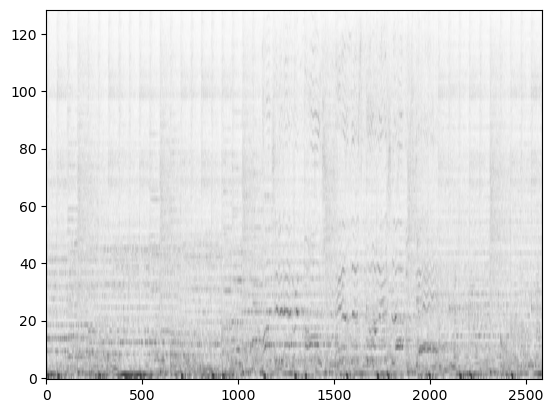

In [10]:
plt.imshow(np.sqrt(np.abs(spectrogram)), aspect = 'auto', origin = 'lower', cmap = 'gist_yarg')
plt.show()

In [11]:
rms = math.sqrt(np.mean(audio ** 2))
for i in range(1500, 2000):
    spectrogram[:, i] += np.random.normal(0, np.sqrt(rms) * 2, spectrogram.shape[0])

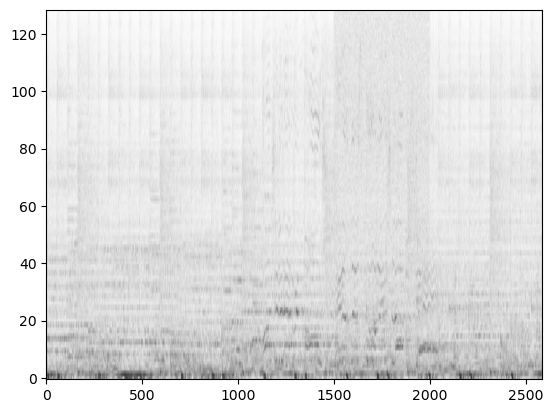

In [12]:
plt.imshow(np.sqrt(np.abs(spectrogram)), aspect = 'auto', origin = 'lower', cmap = 'gist_yarg')
plt.savefig("noisy.png")

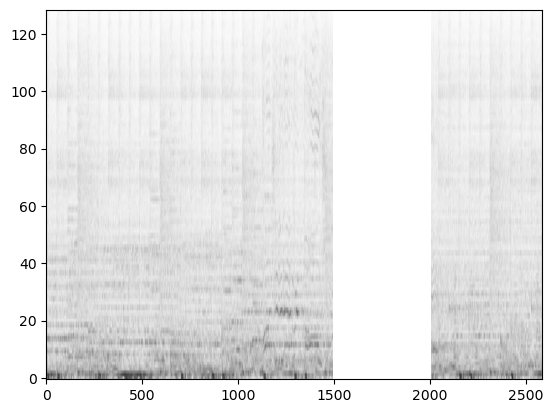

In [13]:
hole = [1 for _ in range(spectrogram.shape[1])]
for i in range(1500, 2000):
    hole[i] = np.nan
new_spectrogram = spectrogram * hole
plt.imshow(np.sqrt(np.abs(new_spectrogram)), aspect = 'auto', origin = 'lower', cmap = 'gist_yarg')
plt.savefig("removed.png")

In [91]:
def spectogram_nmf(spectogram, num_iter = 100):
  X = spectogram.copy()

  m, n = X.shape
  rank = 100
  W = np.random.rand(X.shape[0], rank)
  H = np.random.rand(rank, X.shape[1])

  for _ in range(num_iter):
    H = H * (W.T.dot(X) / (W.T.dot(W).dot(H) + 1e-6))
    W = W * (X.dot(H.T) / (W.dot(H).dot(H.T) + 1e-6))

  return W, H

In [165]:
from sklearn.impute import KNNImputer

In [166]:
imputer = KNNImputer(n_neighbors=2, weights="uniform")

In [167]:
y = imputer.fit_transform(np.abs(new_spectrogram))

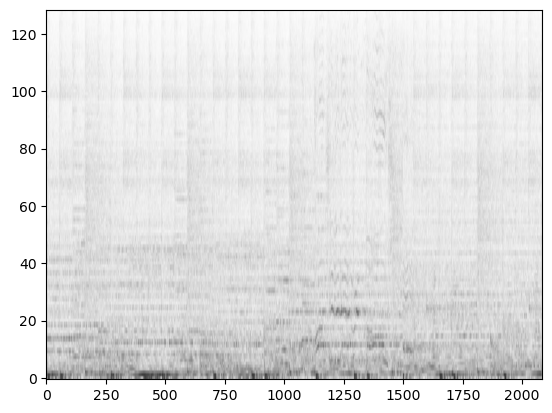

In [168]:
plt.imshow(np.sqrt(np.abs(y)), aspect = 'auto', origin = 'lower', cmap = 'gist_yarg')
plt.savefig("imputed.png")

In [23]:
def em_svd(spectrogram: np.ndarray, maxiter = 10) -> np.ndarray:
    """
    Approximate SVD on data with missing values via expectation-maximization

    Arguments:
        spectrogram: (num_observations, num_dimensions) data matrix, missing values denoted by np.nan

    Returns:
        imputed_spectrogram: (num_observations, num_dimensions) reconstructed data matrix
    """

    mu_hat = np.nanmean(spectrogram, axis=1, keepdims=1)
    valid = np.isfinite(spectrogram)
    imputed_spectrogram = np.where(valid, spectrogram, mu_hat)

    run = True
    iter = 1
    v_prev = 0

    while run:

        # SVD on filled-in data
        U, s, Vt = np.linalg.svd(imputed_spectrogram - mu_hat, full_matrices=False)

        # impute missing values
        imputed_spectrogram[~valid] = (U.dot(np.diag(s)).dot(Vt) + mu_hat)[~valid]

        # update bias parameter
        mu_hat = imputed_spectrogram.mean(axis=0, keepdims=1)

        # test convergence using relative change in trace norm
        v = s.sum()
        if iter >= maxiter or ((v - v_prev) / v_prev) < 1e-6:
            run = False
        iter += 1
        v_prev = v
    
    return imputed_spectrogram

In [24]:
imputed_spectrogram = em_svd(np.abs(new_spectrogram))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Int

/var/folders/9j/3f93mpv53rg35bffhmbs3vxc0000gn/T/ipykernel_23577/3426466975.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  if iter >= maxiter or ((v - v_prev) / v_prev) < 1e-6:


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.I



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions

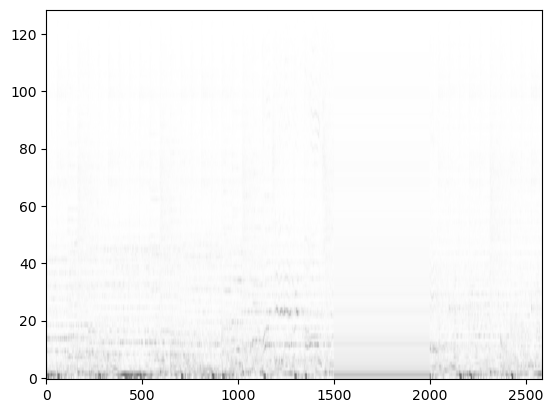

In [25]:
plt.imshow(imputed_spectrogram, aspect = 'auto', origin = 'lower', cmap = 'gist_yarg')